In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.concat([
    pd.read_csv('../../DATA/FINAL/training_data_2016.csv'),
    pd.read_csv('../../DATA/FINAL/training_data_2017.csv'),
    pd.read_csv('../../DATA/FINAL/training_data_2018.csv'),
    pd.read_csv('../../DATA/FINAL/training_data_2019.csv')

], axis = 0)

In [13]:
predictors = [
    'L3',
    'L2',
    'L1',
    'CF_CL',
    'CASH_TA',
    'SAL_TA',
    'TL_SAL',
    'INV_COST',
    'INV_SAL',
    'CC_SAL',
    'TA_SAL',
    'TL_TA',
    'CF_TL',
    'CL_TA',
    'NCL_TA',
    'EQ_TL',
    'EQ_TA',
    'CL_CC',
    'ROE',
    'EAT_TA',
    'ROA_BRUTTO',
    'CF_TA',
    'CF_SAL',
    'ROS',
    'EAT_YIE',
    'ROI',
    'ROA_NETTO',
    'LABOR_PRODUCTIVITY',
    'SOCLIAB_SAL']

primary_values = [     'CA', 'CASH', 'CL', 'EQ', 'NCL', 'TA', 'TL',
     'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN', 'EAT', 'EBIT', 'SAL', 'COST',
     'INT', 'YIE']

print(len(predictors))

predictors_previous = [col + '_previous' for col in predictors]
predictors_yty = [col + '_yty' for col in predictors]

predictors_extended = predictors + predictors_previous + predictors_yty + primary_values
predictors_2y_abs = predictors + predictors_previous
predictors_2y_rel = predictors + predictors_yty

29


In [4]:
def process_issues(row):
    EQ_TL = row.EQ_TL
    EQ = row.EQ
    L2 = row.L2
    EAT = row.EAT
    y = row.year

    if y <= 2016: threat_criterion = 0.04
    elif y == 2017: threat_criterion = 0.06
    else: threat_criterion = 0.08

    if EQ_TL < threat_criterion and EQ < 0 and L2 < 1 and EAT < 0:
        return 1
    return 0

In [5]:
data_next_year = data[['year', 'entity_ico', 'EQ', 'CA', 'CL', 'TL', 'EAT']]
data_next_year['year'] -= 2

data_next_year.columns = ['year', 'entity_ico', 'EQ_2y_off', 'CA_2y_off', 'CL_2y_off', 'TL_2y_off', 'EAT_2y_off']

C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_5544\1962914670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_next_year['year'] -= 2


In [6]:
data = data.merge(data_next_year, on = ['year', 'entity_ico'], how = 'left')

In [8]:
modelling_dataset = data.query('period_length == 12 and sal_class in ["2. Malý",  "3. Stredný"] and financial_report_template_id == 699 and is_outlier == False')

In [9]:
SAL_CLASSES = sorted(modelling_dataset['sal_class'].unique())
# SKNACE_GROUPS = data_2017['sknace_division'].unique()
SKNACE_GROUPS = ['G', 'C', 'F', 'H', 'M', 'N', 'L']

In [10]:
from sklearn.impute import SimpleImputer


def fill_missing_values_mean(data):
    # Instantiate SimpleImputer with mean strategy
    imputer = SimpleImputer(strategy='mean')

    # Fit the imputer on the data and transform the data
    imputed_data = imputer.fit_transform(data)

    return imputed_data

training_data_filled = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        # print(f'sales_class: {sal_class}; sknace: {sknace}')
        subset_training = modelling_dataset.query('sal_class == @sal_class and sknace_division == @sknace')
        for col in predictors_extended:
            col_mean = subset_training[col].mean()
            subset_training[col] = subset_training[col].fillna(col_mean)       

        training_data_filled = pd.concat([training_data_filled, subset_training], axis = 0)

display(training_data_filled.shape[0])


C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_5544\168347275.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_training[col] = subset_training[col].fillna(col_mean)


27887

In [49]:
# Importing necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


records = []
selected_features = ['CA', 'YIE', 'CC', 'CC_SAL', 'CF_NETTO', 'SAL_TA', 'INV_SAL']

for candidate_feature in predictors_extended:
    row = [selected_features, candidate_feature]
    # Generating some sample data


    X = training_data_filled.query('CA_2y_off == CA_2y_off')[selected_features + [candidate_feature]]
    y = training_data_filled.query('CA_2y_off == CA_2y_off')['CA_2y_off']

    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_cleaned = X[(y >= lower_bound) & (y <= upper_bound)]
    y_cleaned = y[(y >= lower_bound) & (y <= upper_bound)]

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

    # Creating and training the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Making predictions on the testing set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    
    # Evaluating the model
    row.append(mse)
    row.append(r2)

    records.append(row)
    

display(pd.DataFrame(records, columns=['selected_features', 'candidate_feature', 'MSE', 'R2']).sort_values('MSE', ascending=True))



,selected_features,candidate_feature,MSE,R2
27,"[CA, YIE, CC, CC_SAL, CF_NETTO, SAL_TA, INV_SAL]",LABOR_PRODUCTIVITY,1.324371e+12,0.527678
43,"[CA, YIE, CC, CC_SAL, CF_NETTO, SAL_TA, INV_SAL]",NCL_TA_previous,1.327206e+12,0.526667
22,"[CA, YIE, CC, CC_SAL, CF_NETTO, SAL_TA, INV_SAL]",CF_SAL,1.328029e+12,0.526373
16,"[CA, YIE, CC, CC_SAL, CF_NETTO, SAL_TA, INV_SAL]",EQ_TA,1.328394e+12,0.526244
28,"[CA, YIE, CC, CC_SAL, CF_NETTO, SAL_TA, INV_SAL]",SOCLIAB_SAL,1.328686e+12,0.526139
...,...,...,...,...
13,"[CA, YIE, CC, CC_SAL, CF_NETTO, SAL_TA, INV_SAL]",CL_TA,1.342029e+12,0.521381
30,"[CA, YIE, CC, CC_SAL, CF_NETTO, SAL_TA, INV_SAL]",L2_previous,1.349122e+12,0.518851
29,"[CA, YIE, CC, CC_SAL, CF_NETTO, SAL_TA, INV_SAL]",L3_previous,1.350187e+12,0.518471
44,"[CA, YIE, CC, CC_SAL, CF_NETTO, SAL_TA, INV_SAL]",EQ_TL_previous,1.362226e+12,0.514178


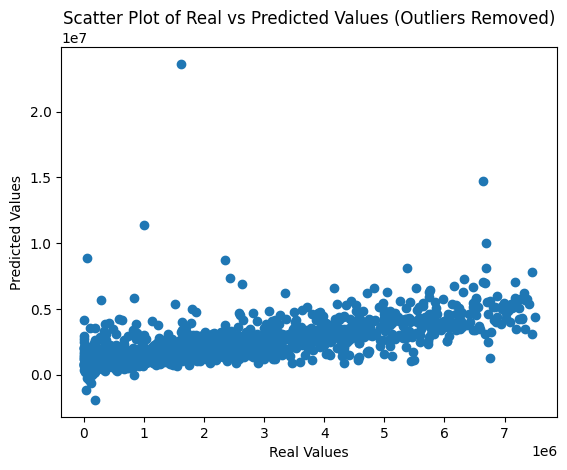

In [50]:

import matplotlib.pyplot as plt

# Plotting the scatter plot
plt.scatter(y_test, y_pred)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of Real vs Predicted Values (Outliers Removed)")
plt.show()

In [60]:
sample.query('TL_SAL > 5')

,financial_report_id,financial_statement_id,financial_report_order_number,entity_id,approved_date,entity_ico,year,month,financial_report_template_id,entity_name,...,ROI_yty,ROA_NETTO_yty,LABOR_PRODUCTIVITY_yty,SOCLIAB_SAL_yty,has_3y_history,EQ_2y_off,CA_2y_off,CL_2y_off,TL_2y_off,EAT_2y_off
606968,6798217,4107743,1,1802975,2019-06-20,51967367.0,2018,1,699.0,"INVEST - K, s.r.o.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
predicted_value = 'CA'


sample = modelling_dataset.sample(100)[predictors_extended + ['EQ_2y_off', 'CA_2y_off', 'CL_2y_off', 'TL_2y_off', 'EAT_2y_off']].corr()
sample[['EQ_2y_off', 'CA_2y_off', 'CL_2y_off', 'TL_2y_off', 'EAT_2y_off']].iloc[:-5, :].sort_values('EQ_2y_off')

,EQ_2y_off,CA_2y_off,CL_2y_off,TL_2y_off,EAT_2y_off
TL_TA_previous,-0.414108,-0.196278,0.041548,0.070927,-0.121222
TL_TA,-0.385100,-0.086716,0.088311,0.177713,-0.144503
CL_TA_previous,-0.362725,-0.125795,0.097509,-0.102931,0.003864
CL_TA,-0.302552,-0.040123,0.168691,-0.087771,0.043982
SAL_TA,-0.297029,-0.294307,-0.304498,-0.451481,0.143664
...,...,...,...,...,...
TA,0.622509,0.547948,0.624320,0.847558,-0.305873
COST,0.722076,0.639494,0.778282,0.679769,-0.145916
YIE,0.755995,0.650870,0.763648,0.591105,-0.026556
SAL,0.758792,0.656340,0.752469,0.581518,-0.017909


In [48]:
pd.DataFrame(zip(y_test, y_pred)).apply(pd.to_numeric)

,0,1
0,1719930.0,1.899009e+06
1,389576.0,9.200654e+05
2,7326409.0,6.188545e+06
3,1390961.0,1.411585e+06
4,1994138.0,1.565185e+06
...,...,...
2328,650459.0,1.000449e+06
2329,434324.0,1.405441e+06
2330,415562.0,3.905025e+06
2331,2691637.0,1.661441e+06
